# Model Analysis

### Table of Contents

1. Best Model Selection
2. EDA On Best Model
3. Feature Engineering
4. Model Improvement
5. Summary

### 1. Best Model Selection:

Based on the various models built on our dataset. We would like to find out the best performing model for further analysis. We cannot select a model based on a single run with the dataset. The model might be data bias and therefore we have decided to select the **Top 2** performing models from our previous analysis.

These models are:
-  **Voting Regressor**
-  **Stacking Regressor**

We would only use these 2 models from now on to further optimize our results.

#### 1.1 Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from statsmodels import robust
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
import math
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from prettytable import PrettyTable 

#### 1.2 Loading the Preprocessed Dataset

In [280]:
df = pd.read_csv('result.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'cuisines', 'approx_cost(for two people)',
       'listed_in(type)', 'listed_in(city)', 'avg_user_rating', 'user_votes',
       'total_cuisines', 'multitype_restaurant', 'RevPASH', 'Total_P',
       'Male_P', 'Female_P', 'Grocery_conc', 'Restaurant_conc', 'Cafe_conc',
       'class_label'],
      dtype='object')

In [281]:
df.drop(columns=['rate','class_label'],inplace=True)
X = df.drop('avg_user_rating',axis=1)
y = df['avg_user_rating']
print(X.shape)
print(y.shape)

(46142, 20)
(46142,)


In [283]:
# We define a function categorical to encode our  categorical and binary features
# We encode them using OneHotEncoding, we fit the Encoder on our training data
# Then we transform both the training and test feature data.
# We return the encoded feature values.

def categorical(X_train,X_test,y_train,y_test,feature):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(X_train[feature].values.reshape(-1, 1))
    X_train_feature = enc.transform(X_train[feature].values.reshape(-1, 1))
    X_test_feature = enc.transform(X_test[feature].values.reshape(-1, 1))
    return X_train_feature,X_test_feature

In [285]:
# We define a function numerical to normalize our  numerical features
# We normalize them using MinMaxScalar, we fit the Normalizer on our training data
# Then we transform both the training and test feature data.
# We return the Normalized feature values.


def numerical(X_train,X_test,feature):
    norm = MinMaxScaler()
    norm.fit(X_train[feature].values.reshape(-1,1))
    X_Train_bow = norm.transform(X_train[feature].values.reshape(-1,1))
    X_Test_bow = norm.transform(X_test[feature].values.reshape(-1,1))
    return  X_Train_bow, X_Test_bow

In [326]:
# We define a function transform that takes the train and test data after splitting
# This function performs onehotencoding and normalization of numeric features using the above 2 defined functions
# It resturns a dataframe of the encoded features ready to be modeled

def transform(X_train,X_test):
    X_train_order,X_test_order = categorical(X_train,X_test,y_train,y_test,'online_order')
    X_train_book,X_test_book = categorical(X_train,X_test,y_train,y_test,'book_table')
    X_train_multi,X_test_multi = categorical(X_train,X_test,y_train,y_test,'multitype_restaurant')
    X_train_location,X_test_location = categorical(X_train,X_test,y_train,y_test,'location')
    X_train_rest,X_test_rest = categorical(X_train,X_test,y_train,y_test,'rest_type')
    X_train_type,X_test_type = categorical(X_train,X_test,y_train,y_test,'listed_in(type)')
    X_train_city,X_test_city = categorical(X_train,X_test,y_train,y_test,'listed_in(city)')

    X_train_votes,X_test_votes = numerical(X_train,X_test,'votes')
    X_train_uv,X_test_uv = numerical(X_train,X_test,'user_votes')
    X_train_cost,X_test_cost = numerical(X_train,X_test,'approx_cost(for two people)')
    X_train_tc,X_test_tc = numerical(X_train,X_test,'total_cuisines')
    X_train_rv,X_test_rv = numerical(X_train,X_test,'RevPASH')
    X_train_tp,X_test_tp = numerical(X_train,X_test,'Total_P')
    X_train_mp,X_test_mp = numerical(X_train,X_test,'Male_P')
    X_train_fp,X_test_fp = numerical(X_train,X_test,'Female_P')
    X_train_gc,X_test_gc = numerical(X_train,X_test,'Grocery_conc')
    X_train_rc,X_test_rc = numerical(X_train,X_test,'Restaurant_conc')
    X_train_cc,X_test_cc = numerical(X_train,X_test,'Cafe_conc')
    
    X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_location,X_train_rest,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
    X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_location,X_test_rest,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
    X_tr = pd.DataFrame(X_tra.toarray())
    X_te = pd.DataFrame(X_tes.toarray())
    return X_tr,X_te

In [353]:
# We define a function comparison to compare the top 2 models from our previous analysis
# We create 2 lists R2 and RMSE to store the respective performance metric
# The function takes any one model at a time and runs a loop 10 times.
# Each time the dataset is splitted and made to run through the specific model
# After each iteration the R2 and RMSE score is stored in their respective list
# We return the list for further analysis


def comparison(model):
    r2=[]
    rmse=[]
    for i in tqdm(range(0,10)):
        print('{}th Iteration :'.format(i))
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)
        print(X_train.shape,y_train.shape)
        print(X_test.shape,y_test.shape)
        X_tr,X_te = transform(X_train,X_test)
        model.fit(X_tr,y_train)
        test_pred = model.predict(X_te)
        mse_test = mean_squared_error(y_test, test_pred)
        print("Root Mean Square Error of the model is {}".format(math.sqrt(mse_test)))
        print("R² of the model is {}".format(r2_score(y_test, test_pred)))
        r2.append(r2_score(y_test, test_pred))
        rmse.append(math.sqrt(mse_test))
    return r2,rmse

#### 1.31 Calling the comparison function to run the Stacking Regressor 10 times

In [335]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100)
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
r2_1,rmse_1 = comparison(Sr) 






  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

0th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 10%|████████                                                                        | 1/10 [11:03<1:39:35, 663.98s/it]

Root Mean Square Error of the model is 0.4287211745391616
R² of the model is 0.8692062593985826
1th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 20%|████████████████                                                                | 2/10 [21:57<1:28:06, 660.81s/it]

Root Mean Square Error of the model is 0.44460652900397407
R² of the model is 0.8584028664850052
2th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 30%|████████████████████████                                                        | 3/10 [32:51<1:16:51, 658.73s/it]

Root Mean Square Error of the model is 0.44551591444769184
R² of the model is 0.8550767443075862
3th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 40%|████████████████████████████████                                                | 4/10 [43:59<1:06:09, 661.59s/it]

Root Mean Square Error of the model is 0.4372124185948298
R² of the model is 0.8593986258302329
4th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 50%|█████████████████████████████████████████                                         | 5/10 [54:59<55:05, 661.04s/it]

Root Mean Square Error of the model is 0.4375214685687194
R² of the model is 0.8625278945312395
5th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 60%|████████████████████████████████████████████████                                | 6/10 [1:06:21<44:29, 667.49s/it]

Root Mean Square Error of the model is 0.43862029872137454
R² of the model is 0.8602752575237143
6th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 70%|████████████████████████████████████████████████████████                        | 7/10 [1:17:25<33:19, 666.48s/it]

Root Mean Square Error of the model is 0.4415260066483343
R² of the model is 0.8584848120696349
7th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:28:20<22:05, 662.92s/it]

Root Mean Square Error of the model is 0.44129908948598023
R² of the model is 0.8578583103911175
8th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:39:14<11:00, 660.31s/it]

Root Mean Square Error of the model is 0.4482314156600988
R² of the model is 0.854604711081113
9th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:50:34<00:00, 663.41s/it]

Root Mean Square Error of the model is 0.43382398403962463
R² of the model is 0.8641066707530073


#### 1.32 Calling the comparison function to run the Voting Regressor 10 times

In [354]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) #with loclg, restlg, cuisineslg namelg and listedlg
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Vr = VotingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
r2_2,rmse_2 = comparison(Vr)






  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

0th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 10%|████████▏                                                                         | 1/10 [02:26<22:02, 146.93s/it]

Root Mean Square Error of the model is 0.4418491463089592
R² of the model is 0.8588035469333393
1th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 20%|████████████████▍                                                                 | 2/10 [04:44<19:11, 144.00s/it]

Root Mean Square Error of the model is 0.4315231110287762
R² of the model is 0.8665903057512725
2th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 30%|████████████████████████▌                                                         | 3/10 [07:05<16:42, 143.16s/it]

Root Mean Square Error of the model is 0.4511910162534585
R² of the model is 0.8520642955417589
3th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 40%|████████████████████████████████▊                                                 | 4/10 [09:25<14:14, 142.41s/it]

Root Mean Square Error of the model is 0.4518642900278194
R² of the model is 0.8539962247976384
4th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 50%|█████████████████████████████████████████                                         | 5/10 [11:43<11:44, 140.97s/it]

Root Mean Square Error of the model is 0.45073625226955155
R² of the model is 0.8496846039040146
5th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 60%|█████████████████████████████████████████████████▏                                | 6/10 [14:10<09:30, 142.70s/it]

Root Mean Square Error of the model is 0.44218123833515305
R² of the model is 0.8557811727168383
6th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [16:26<07:02, 140.67s/it]

Root Mean Square Error of the model is 0.4443833928008576
R² of the model is 0.8536822791763896
7th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [18:41<04:38, 139.05s/it]

Root Mean Square Error of the model is 0.4337004305667987
R² of the model is 0.8641115318984013
8th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [20:58<02:18, 138.55s/it]

Root Mean Square Error of the model is 0.44763051535576626
R² of the model is 0.8517716217341718
9th Iteration :
(30915, 20) (30915,)
(15227, 20) (15227,)







100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [23:14<00:00, 139.47s/it]

Root Mean Square Error of the model is 0.4443927178003197
R² of the model is 0.8579299898150048


In [365]:
# We deine a function model_comparison which takes the evaluated R2 and RMSE scores of both the models
# We create a dataframe with R2 and RMSE as features and Model type as Hue
# We plot the distribution plots of both the performance metric to observe their distribution


def model_comparison(r2_1,rmse_1,r2_2,rmse_2):
    r2=[]
    rmse=[]
    m=[]
    for i,j in zip(rmse_1,r2_1):
        rmse.append(i)
        r2.append(j)
        m.append("Stacking Regressor")
    for i,j in zip(rmse_2,r2_2):
        rmse.append(i)
        r2.append(j)
        m.append("Voting Regressor")
    d=pd.DataFrame()
    d['r2'] = r2
    d['rmse'] = rmse
    d['m'] = m
    sns.FacetGrid(d,hue='m',height=6).map(sns.distplot,'r2').add_legend();
    plt.title("Distribution Plot of {} Score".format('r2'))
    plt.show()
    sns.FacetGrid(d,hue='m',height=6).map(sns.distplot,'rmse').add_legend();
    plt.title("Distribution Plot of {} Score".format('rmse'))
    plt.show()

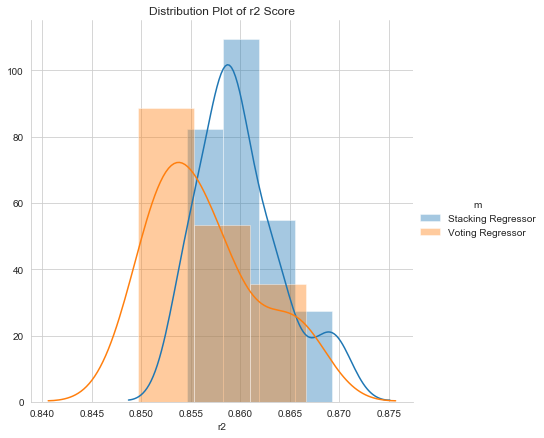

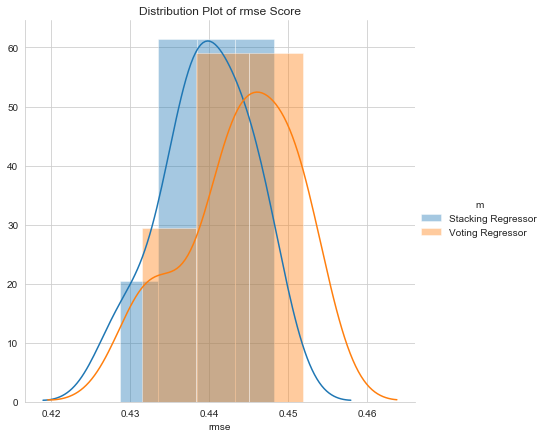

In [366]:
model_comparison(r2_1,rmse_1,r2_2,rmse_2)

#### 1.33 Observation:

-  We can oberve that the distribution of both **Stacking and Voting Regressor are overlapping**, which means there isn't much difference between the results produced by them.
-  The graphs for both the model are spread for both the performance metric, this tells us that there is some **data bias** in our dataset.
-  The **R2 score** for **Stacking regressor** is moving slightly towards **higher value of R2** as compared to Voting, this tells us its performing better in terms of R2.
-  Similarly, the **RMSE score** of **Stacking regressor** is moving slightly towards the **lower side as compared to Voting**, which is again better as we want to **reduce RMSE** for our models.
-  We can finally say that over multiple runs through the dataset, **Stacking Regressor** provides **better results** for our dataset and therefore we would continue our analysis further with only this.

### 2. EDA On Best Model:

After selecting Stacking Regressor as our best performing model. We will try to analyse the results produced by it. We are going to follow the given steps:

-  We define the same **metrics** function as our previous analysis to print the **best results** produced by it.
-  We define a **thershold of rating error** which we consider as **bad** and divide the **test data** on the basis of this threshold.
-  We perform **EDA** on both the new **dataframes** and infer on the results.

In [291]:
# We are defining a function called metrics which would take the best model as input.
# The function would use the model to predict the training and test restaurant ratings, their RMSE and R2 score.
# We will print all the performance metrics related to Training and Test Dataset sepeartely.
# This function will also plot the Predicted and the Original Ratings of the first 75 Restaurants in the form of a line graph.
# This would help us visualize how closely our model is able to predict the ratings and how well it is performing.

def metrics(model):
    
    model.fit(X_tr,y_train)
    train_pred = model.predict(X_tr)
    test_pred = model.predict(X_te)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    mse_train = mean_squared_error(y_train, train_pred)
    
    print("Performace metrics for Training Data :")
    print("Mean Square Error of the model is {}".format(mse_train))
    print("Root Mean Square Error of the model is {}".format(math.sqrt(mse_train)))
    print("R² of the model is {}".format(train_r2))
    
    x = range(len(y_train[:75]))
    plt.plot(x, y_train[:75], label="original")
    plt.plot(x, train_pred[:75], label="predicted")
    plt.title("Original and predicted Ratings for Training Data")
    plt.xlabel('Data Point')
    plt.ylabel('Rating')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.grid(True)
    plt.show()
    print('*'*100)
    
    print("Performace metrics for Test Data :")
    print("Mean Square Error of the model is {}".format(mse_test))
    print("Root Mean Square Error of the model is {}".format(math.sqrt(mse_test)))
    print("R² of the model is {}".format(test_r2))
    
    x = range(len(y_test[:75]))
    plt.plot(x, y_test[:75], label="original")
    plt.plot(x, test_pred[:75], label="predicted")
    plt.title("Original and predicted Ratings for Test Data")
    plt.xlabel('Data Point')
    plt.ylabel('Rating')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.grid(True)
    plt.show()
    print('*'*100)

Performace metrics for Training Data :
Mean Square Error of the model is 0.013101557041806504
Root Mean Square Error of the model is 0.1144620331892043
R² of the model is 0.9905808944388234


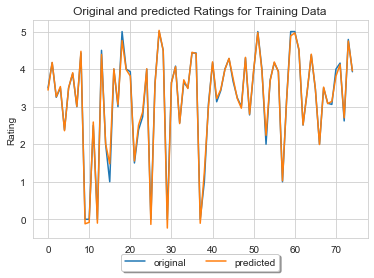

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.18728779175423585
Root Mean Square Error of the model is 0.43276759554550276
R² of the model is 0.862847418564422


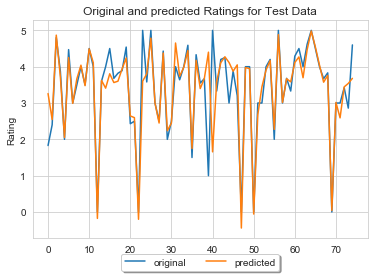

****************************************************************************************************


In [292]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100)
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 2.11 Observations:

-  This model has a **Test RMSE** of **0.4376** which means that our predicted ratings are having a average error value of 0.4376 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.8628** means our model can explain  **86.28%** of the variance in our data, this tells us that this model is able to utilize 86.28% of the features to predict our ratings.

In [492]:
# We define a function analysis that would divide the Test dataset based on the predictions from the best model
# We define a threshold of rating error which we consider as a bad prediction and give "Good" or "Bad" label to the data points
# We divide the dataset based on "Good" and "Bad" points.
# We plot the percentage of points that are "Good" and "Bad"
# We return the "Good" and "Bad" label


def analysis(model):
    pred = model.predict(X_te)
    error=[]
    for i,j in zip(y_test,pred):
        error.append(abs(i-j))
    print("Average error per prediction : {}".format(sum(error)/len(error)))
    
    point=[]
    for i in err:
        if i>= 1.0:  # Threshold of 1 as the deviation in the prediction is greater than 1, then the prediction is bad
            point.append("Bad")
        else:
            point.append("Good")
    g=0
    b=0
    for i in point:
        if i=="Good":
            g=g+1
        else:
            b=b+1
    plt.pie([g,b], labels=['Good','Bad'],autopct='%1.0f%%')
    plt.title('Percentage of predictions that are Good or Bad')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  #https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
          fancybox=True, shadow=True, ncol=5)
    plt.show()
    return point

Average error per prediction : 0.23886145222164384


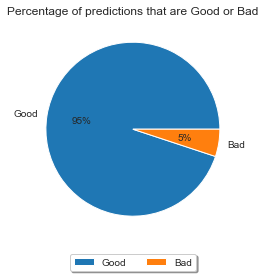

In [482]:
point = analysis(Sr)

#### 2.12 Observations:

-  We can oberve that on a **Rating Error Difference of 1** we have **95% Good** points and **5% Bad** points.
-  The model produced an **Average error** of **0.238** per prediction.

We are adding Point list to our test dataset along with the ratings of these datapoints

In [313]:
X_test["point"] = point
X_test['y'] = y_test

C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [314]:
# We are reusing this function from our previous analysis to make it easier for us to to EDA

def class_labels(DataFrame,Feature):
    class_label=[]
    for i in DataFrame[Feature].values:
        if i<1:
            class_label.append(0)
        elif i>=1 and i<2:
            class_label.append(1)
        elif i>=2 and i<3:
            class_label.append(2)
        elif i>=3 and i<=4:
            class_label.append(3)
        elif i>=4 and i<5:
            class_label.append(4)
        else:
            class_label.append(5)
    return class_label

In [315]:
class_label = class_labels(X_test,'y')
X_test["class_label"] = class_label
X_test.drop(columns=['y'],inplace=True)
df1 = X_test[X_test['point']=='Good']
df2 = X_test[X_test['point']=='Bad']
print(df1.shape)
print(df2.shape)

(14737, 22)
(490, 22)


C:\Users\Kaushal\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Kaushal\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### 2.13 Observations:

-  We have converted the **ratings to a class label** format for easier EDA.
-  We have divided the dataset **X_test** into **df1** with **Good** points and **df2** with **Bad** points.

#### 2.2 Categorical Feature Analysis

In [316]:
# We define a function which prints pie chart for a given dataframe and its specific feature
# We take any categorical feature as input
# We calculate the counts of each category of input and append the category and their respective total counts in 2 seperate lists l1 and l2
# We plot the values with categories and print the percentsge along with it

def pie(Dataframe,feature):
    z = Dataframe[feature].value_counts()
    l1=[]
    l2=[]
    for i in z: # Counts of the categories
        l1.append(i)
    for i in z.keys(): # Category names
        l2.append(i)
    plt.pie(l1, labels=l2,autopct='%1.0f%%')
    plt.title('Percentage of Restaurants having {}'.format(feature))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  #https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
          fancybox=True, shadow=True, ncol=5)
    plt.show()

DataFrame with Good predictions :


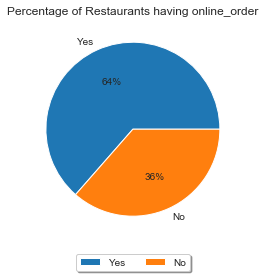

DataFrame with Bad predictions :


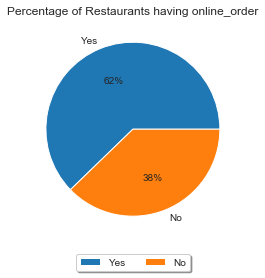

In [317]:
print("DataFrame with Good predictions :")
pie(df1,'online_order')
print("DataFrame with Bad predictions :")
pie(df2,'online_order')

#### 2.21 Observations:

-  We have plotted the pie graph of **Online_order** for both **Good and Bad points**.
-  From the graph its clear that for this feature the distribution of points is **same** for both the Datasets.

DataFrame with Good predictions :


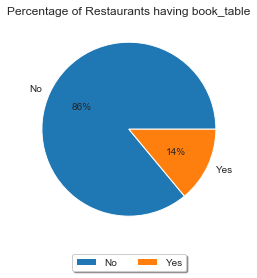

DataFrame with Bad predictions :


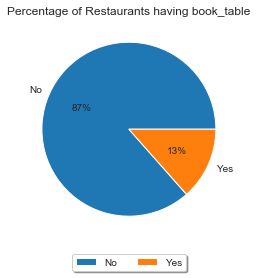

In [318]:
print("DataFrame with Good predictions :")
pie(df1,'book_table')
print("DataFrame with Bad predictions :")
pie(df2,'book_table')

#### 2.22 Observations:

-  Similar to the previous plot, this plot for **book_table** also has almost similar distribution of data points for both the datasets.

DataFrame with Good predictions :


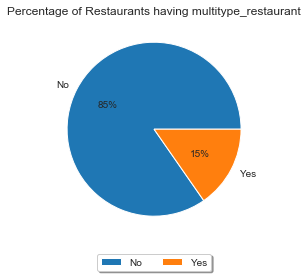

DataFrame with Bad predictions :


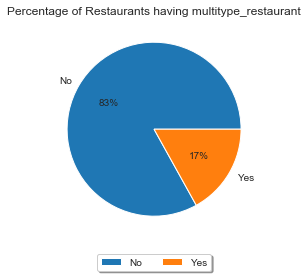

In [319]:
print("DataFrame with Good predictions :")
pie(df1,'multitype_restaurant')
print("DataFrame with Bad predictions :")
pie(df2,'multitype_restaurant')

#### 2.23 Observations:

-  Similar to the previous plot, this plot for **multitype_restaurant** also has almost similar distribution of data points for both the datasets.
-  Since nothing could be said about the distribution of datasets we try to plot a different analysis.

#### 2.3 Bar Graphs

In [320]:
def bar_graph(dataframe,feature):
    z = dataframe[feature].value_counts()
    plt.figure(figsize = (30, 20))
    plt.bar(z.keys(),z, color='maroon')
    plt.xlabel(feature)
    plt.ylabel('Number of Restaurant')
    plt.title('Number of Restaurant per {}'.format(feature))
    plt.show()

DataFrame with Good predictions :


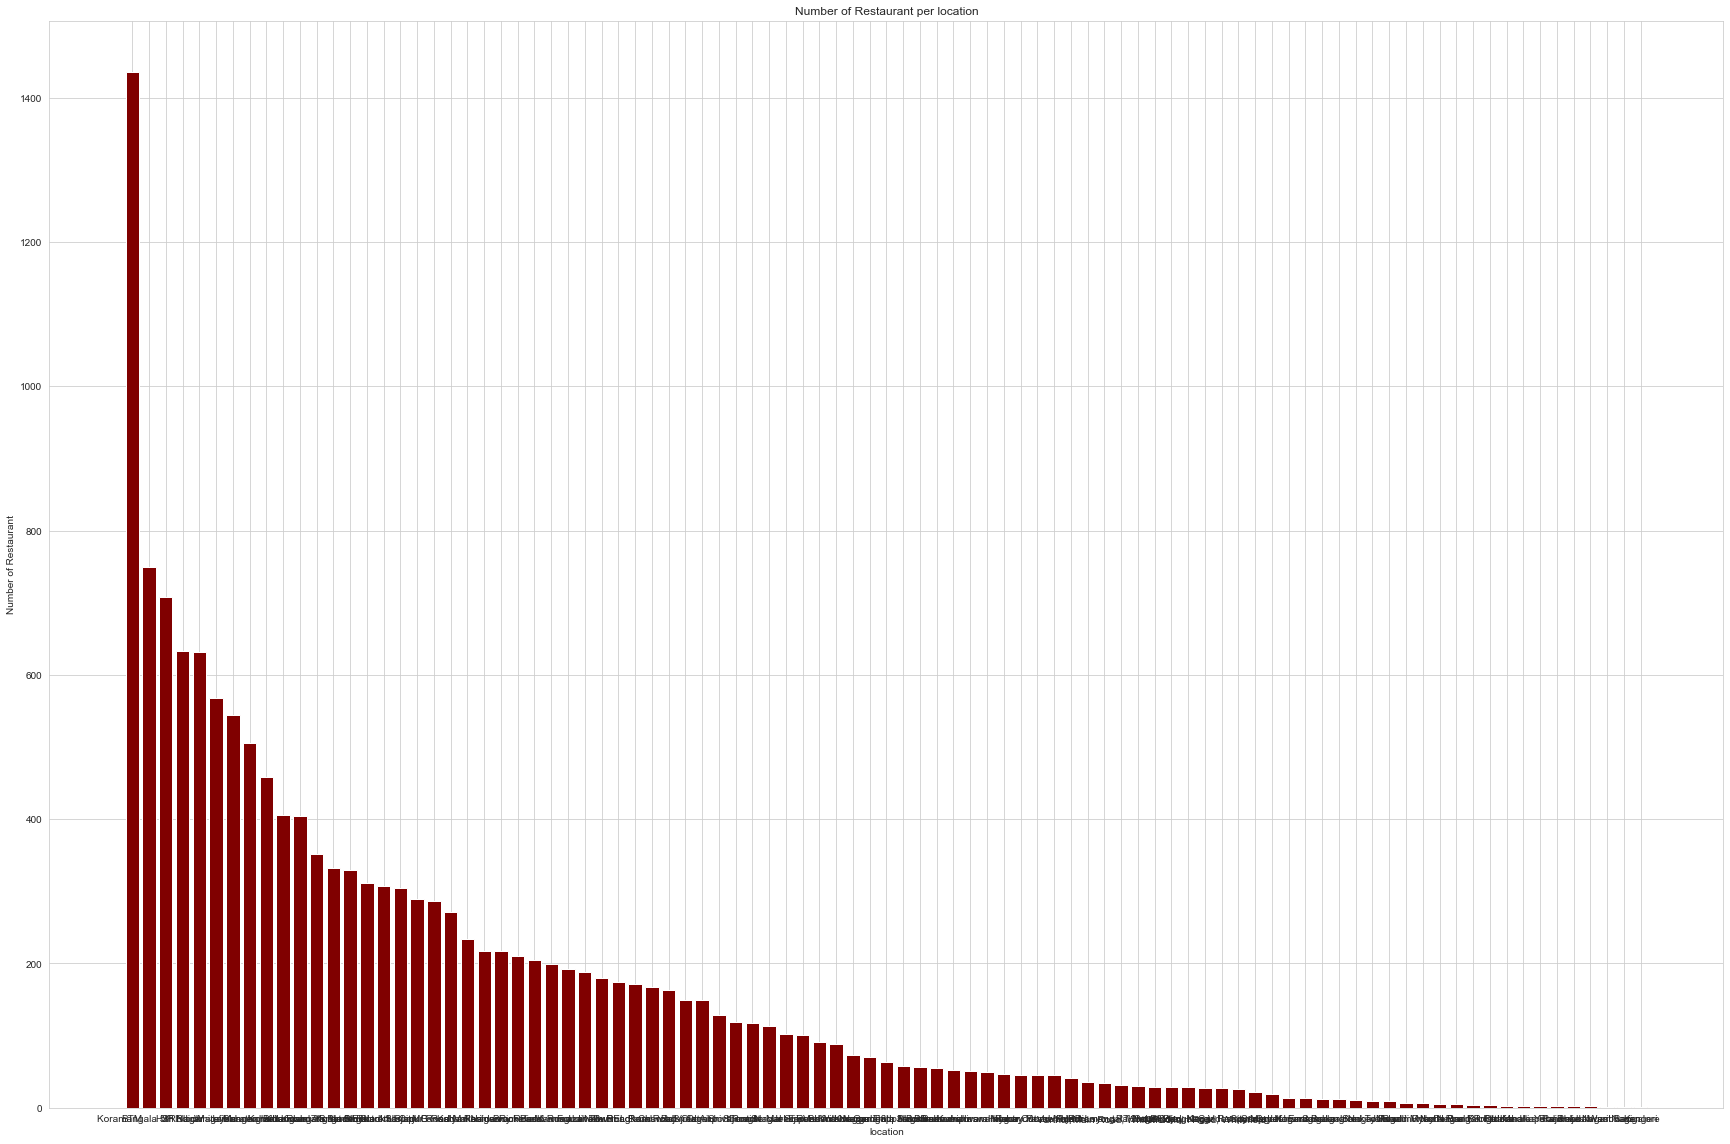

DataFrame with Bad predictions :


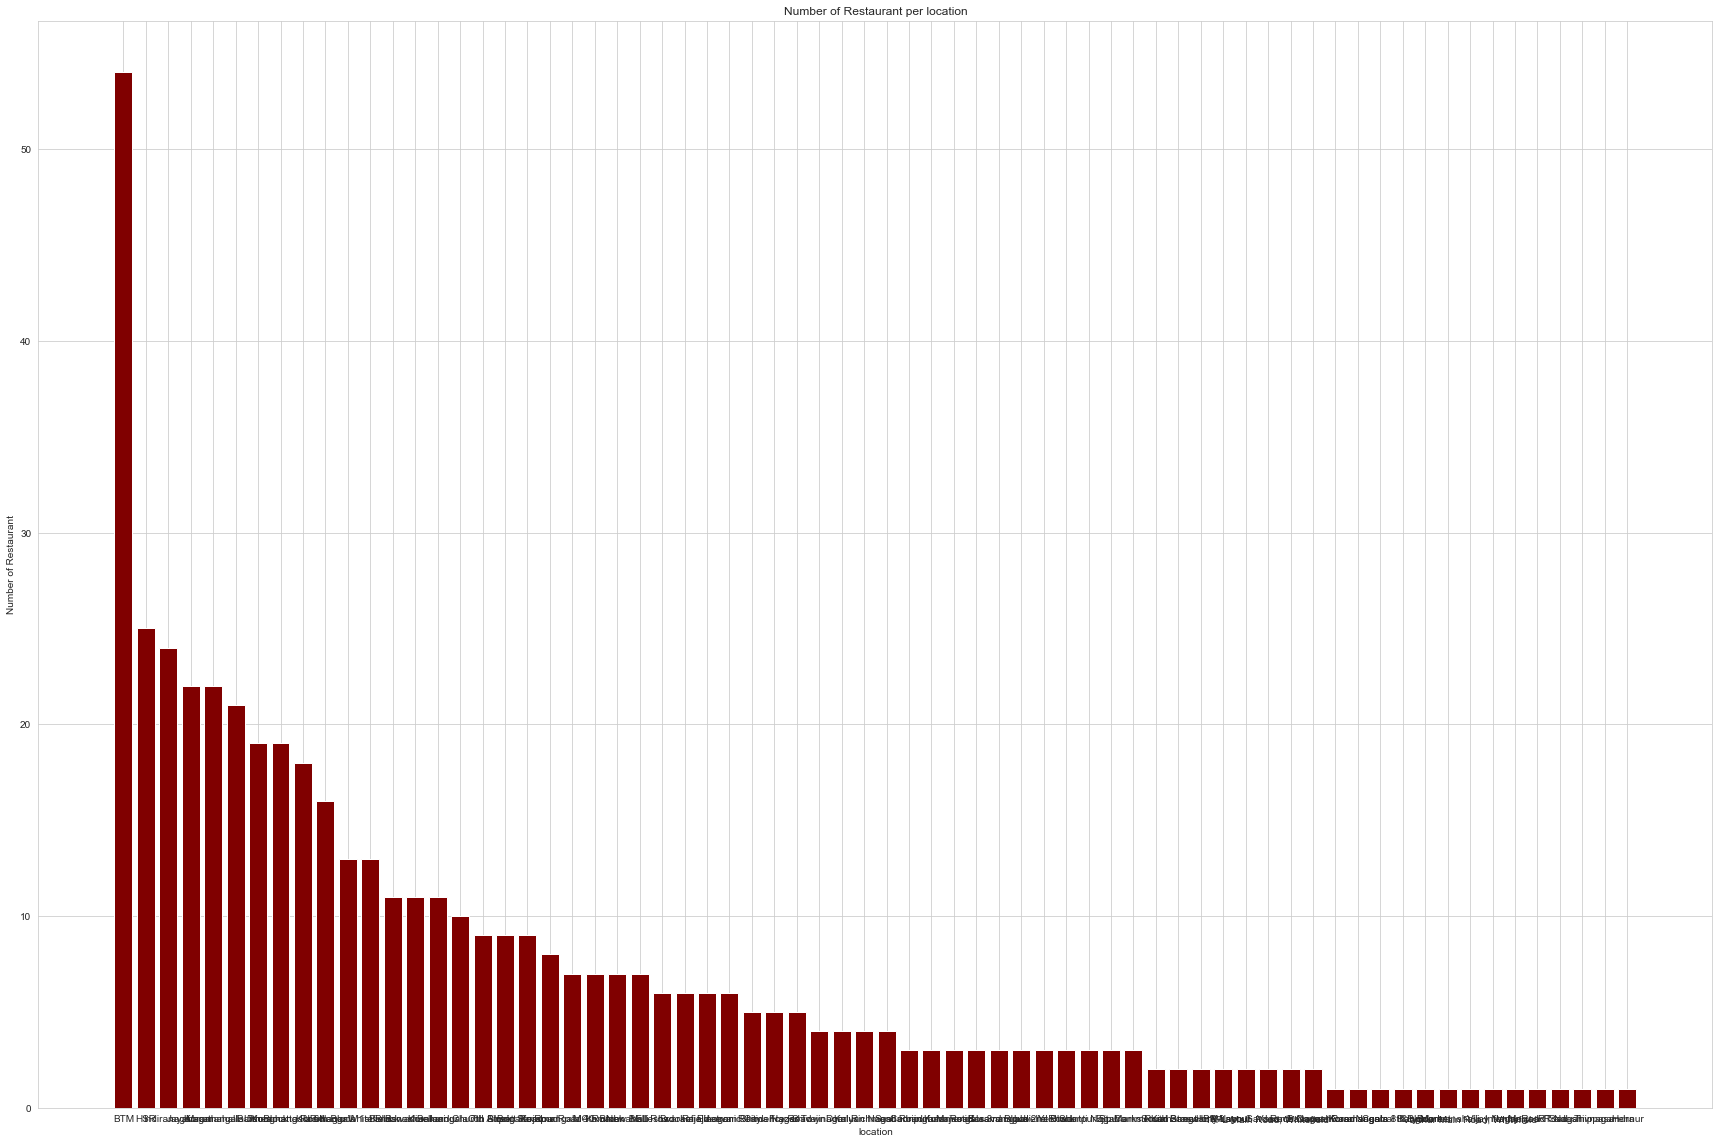

In [321]:
print("DataFrame with Good predictions :")
bar_graph(df1,'location')
print("DataFrame with Bad predictions :")
bar_graph(df2,'location')

#### 2.31 Observations:

-  We can observe that, the bar graph for **df2** is highly **right skewed** as compared to **df1** which has **Good points**.
-  We can also say that both these distributions follow **Power Law**, therefore we could perform some sort of feature engineering to utilize this data.
-  As there are a lot of categories of data in this feature and a lot of them have **Bad points** we would try to look at location feature more carefully before modelling with it.

DataFrame with Good predictions :


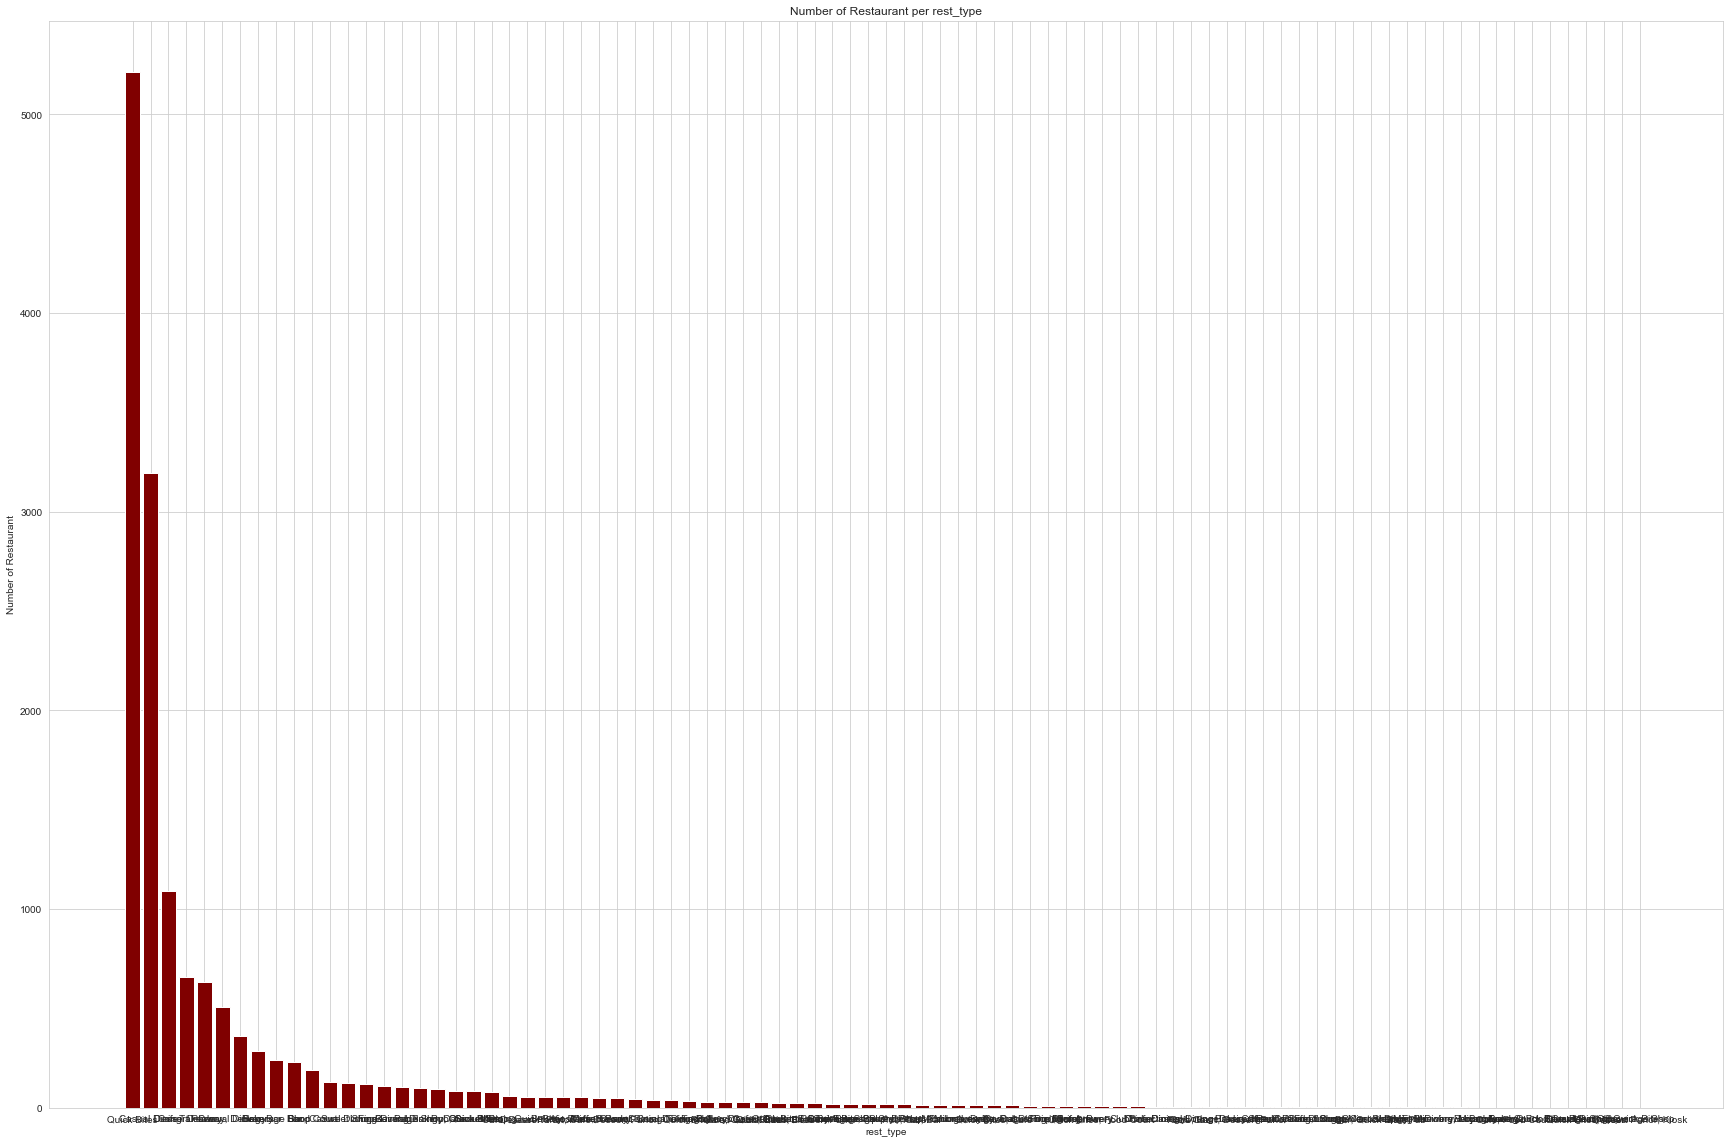

DataFrame with Bad predictions :


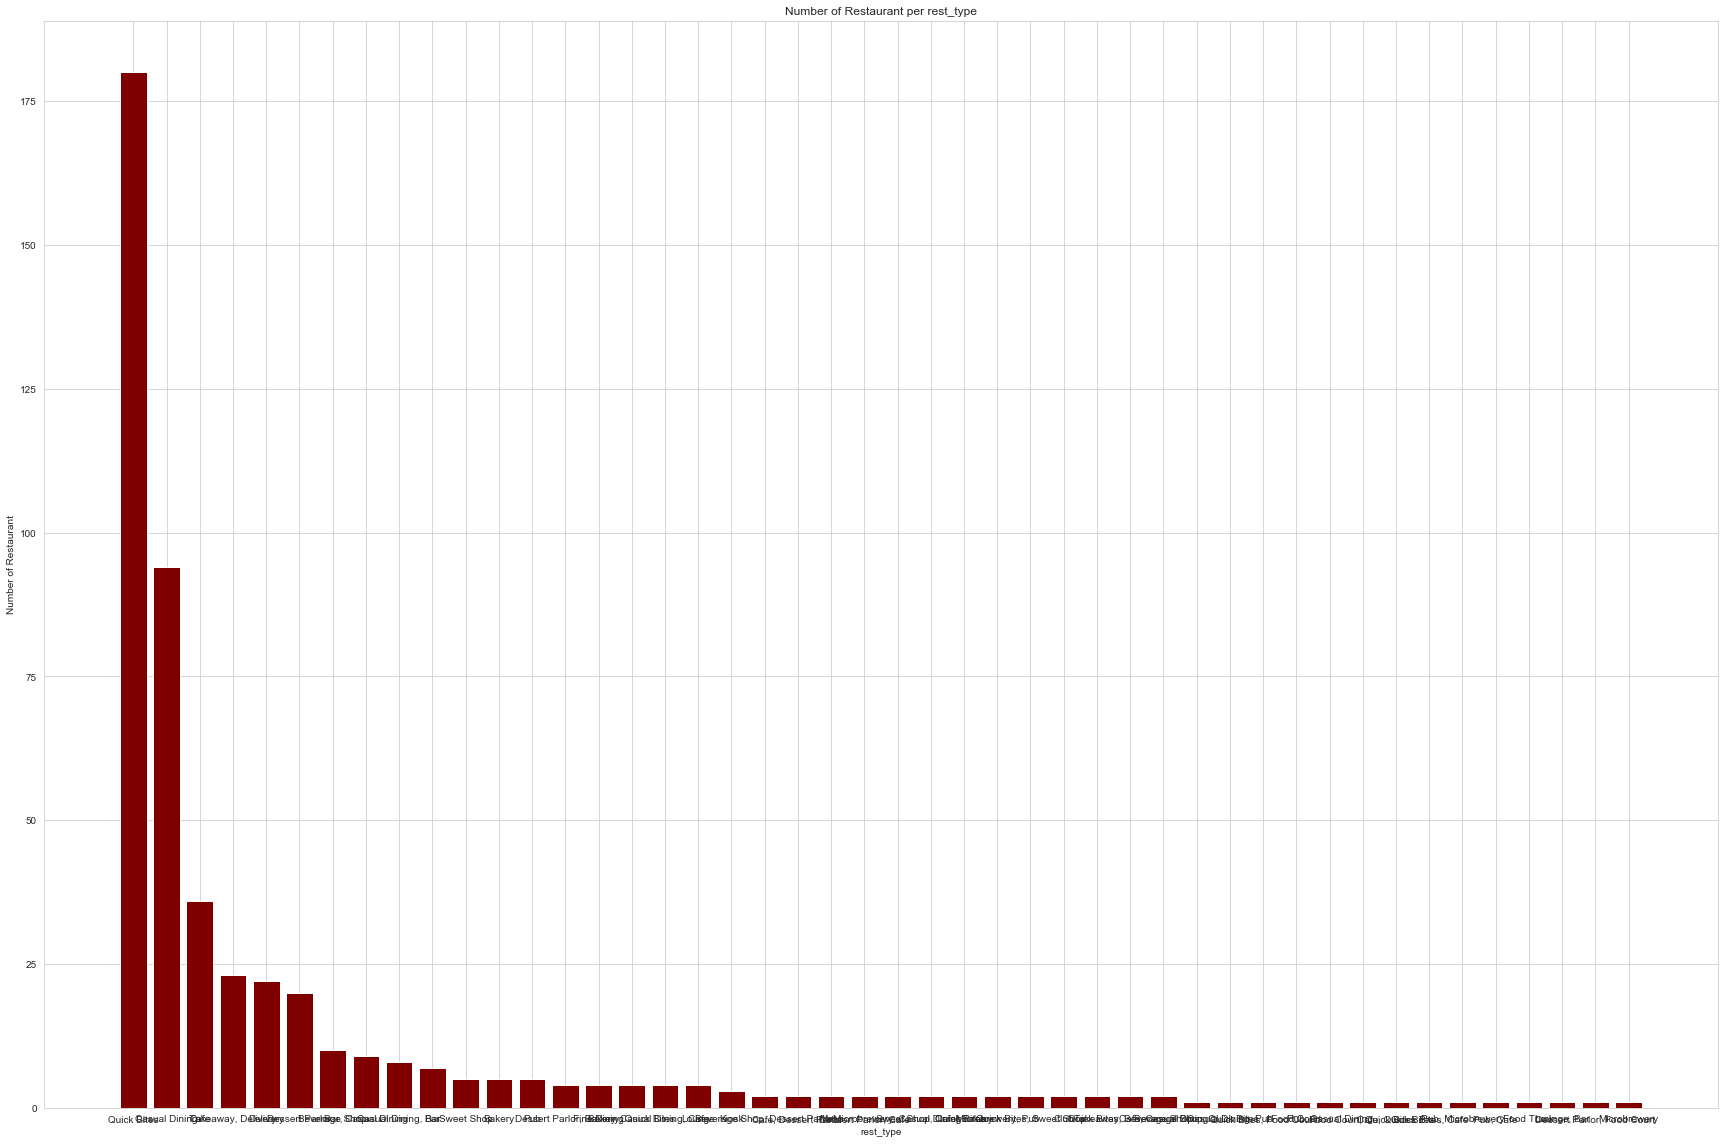

In [322]:
print("DataFrame with Good predictions :")
bar_graph(df1,'rest_type')
print("DataFrame with Bad predictions :")
bar_graph(df2,'rest_type')

#### 2.32 Observations:

-  Similar to the previous plot, the bar graph for **df2** is highly **right skewed** as compared to **df1** which has **Good points**.
-  We can also say that both these distributions follow **Power Law**, therefore we could perform some sort of feature engineering to utilize this data.
-  This has more categories as compared to location and therefore, must be evaluated further.

DataFrame with Good predictions :


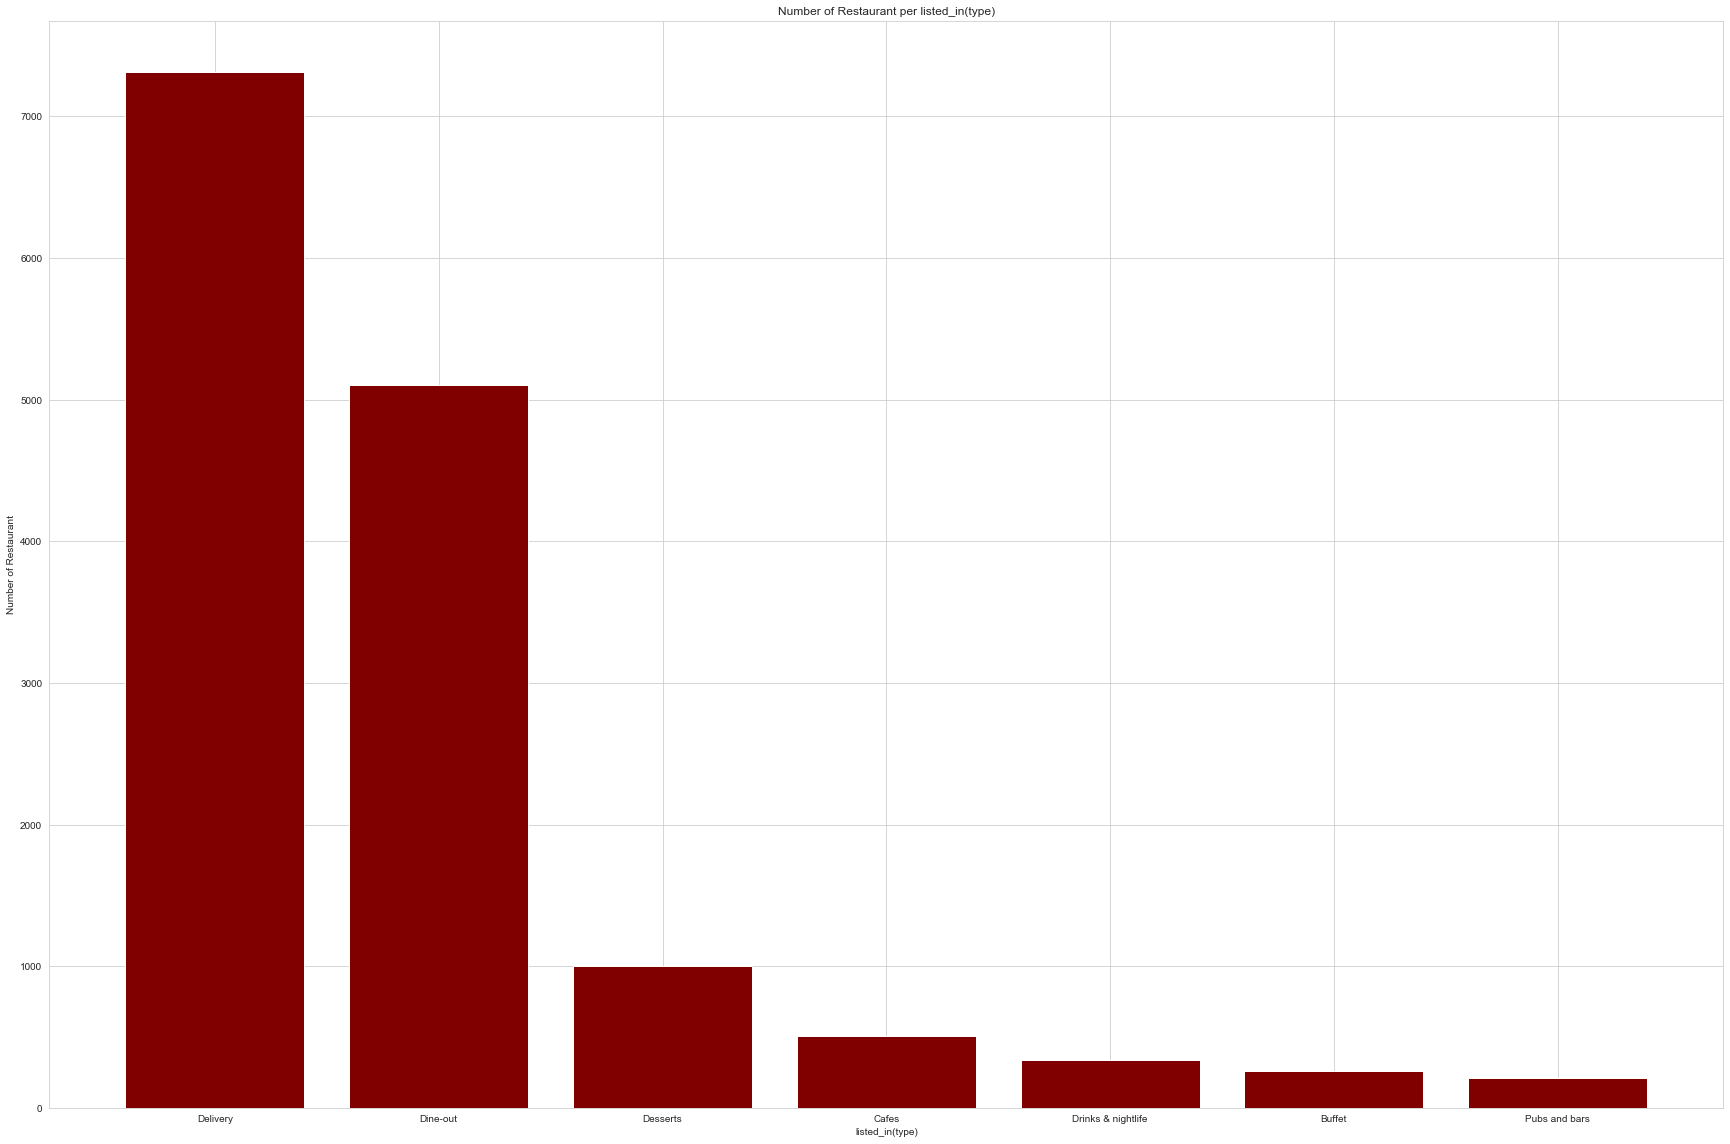

DataFrame with Bad predictions :


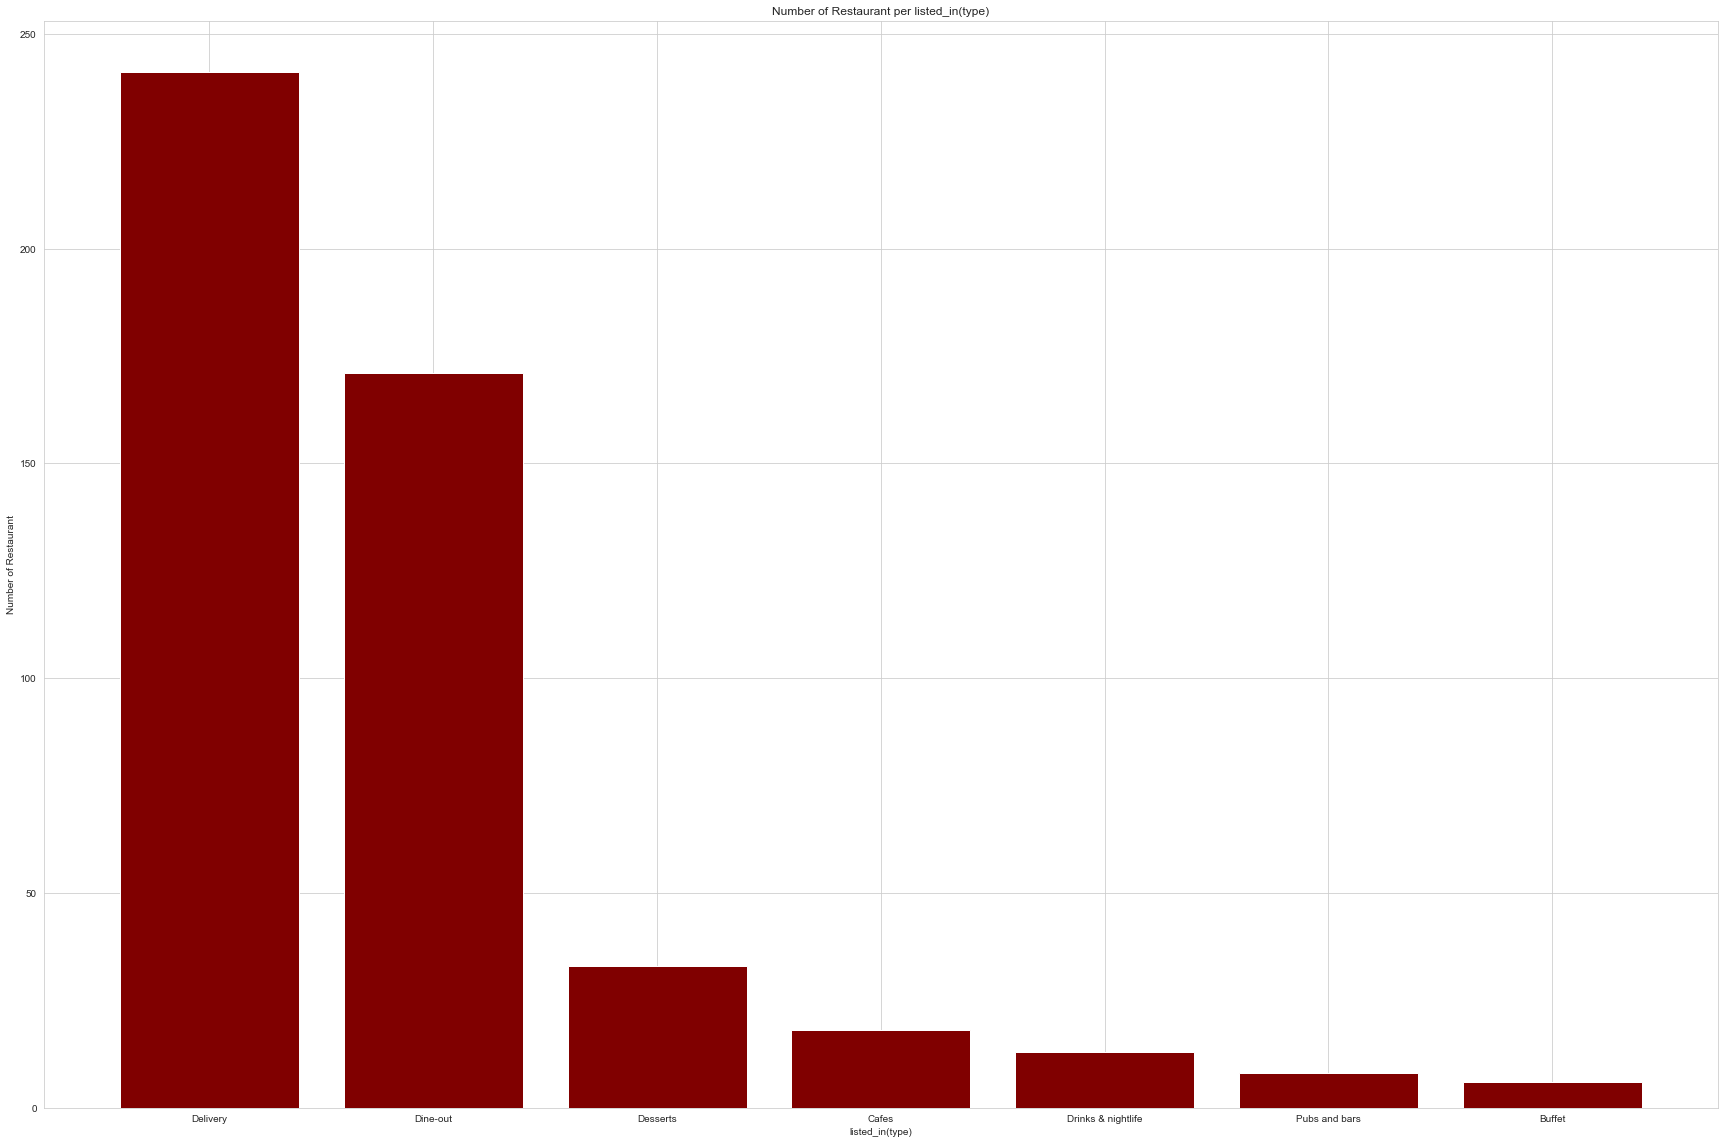

In [323]:
print("DataFrame with Good predictions :")
bar_graph(df1,'listed_in(type)')
print("DataFrame with Bad predictions :")
bar_graph(df2,'listed_in(type)')

#### 2.33 Observations:

-  Unlike the previous two plots, this one has very **less categories**
-  But, this feature also seem to follow **Power law** for both the Datasets which would also require further feature engineering. 

#### 2.4 Distribution Plots

To analyse our numeric features further we plot distribution plots for them for both the datasets

In [367]:
# We define a function to plot the distribution graph of a given feature
def distribution_plot(Dataframe,feature):
    sns.FacetGrid(Dataframe,hue='class_label',height=6).map(sns.distplot,feature).add_legend();
    plt.title("Distribution Plot of {}".format(feature))
    plt.show()

DataFrame with Good predictions :


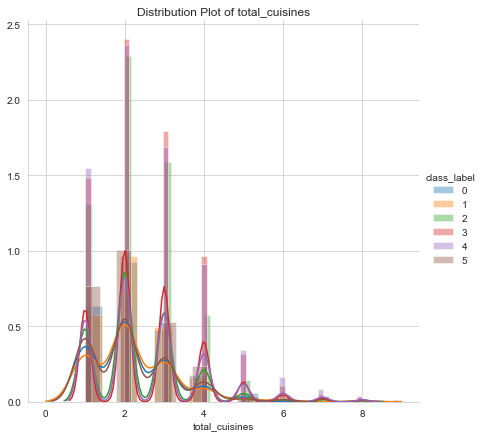

DataFrame with Bad predictions :


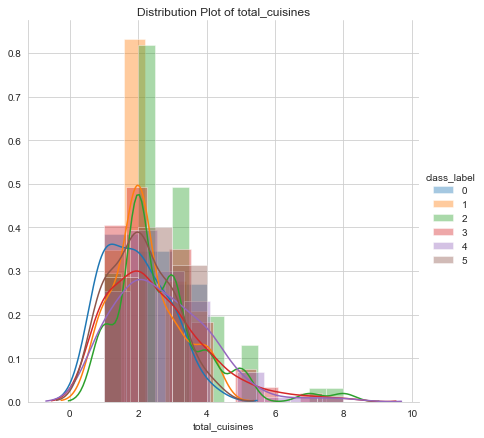

In [368]:
print("DataFrame with Good predictions :")
distribution_plot(df1,'total_cuisines')
print("DataFrame with Bad predictions :")
distribution_plot(df2,'total_cuisines')

-  We cannot oberve any major difference between the plots of **Good** and **Bad** points.

DataFrame with Good predictions :


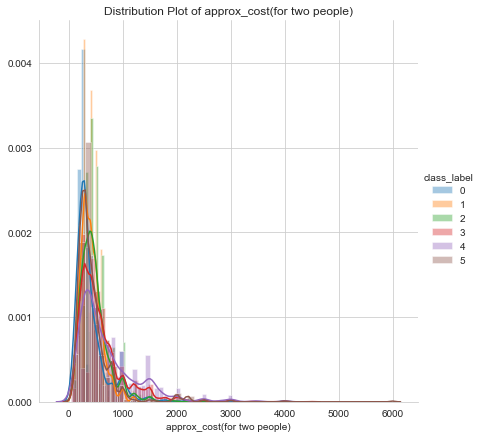

DataFrame with Bad predictions :


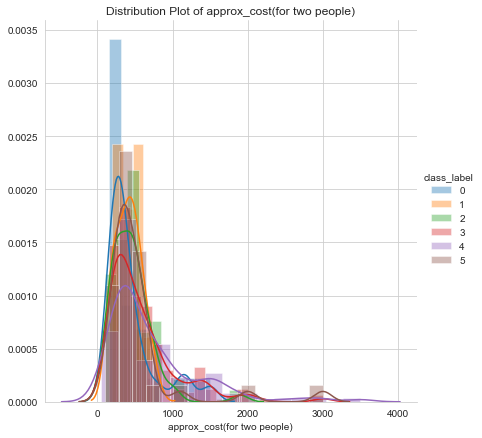

In [369]:
print("DataFrame with Good predictions :")
distribution_plot(df1,'approx_cost(for two people)')
print("DataFrame with Bad predictions :")
distribution_plot(df2,'approx_cost(for two people)')

-  We cannot oberve any major difference between the plots of **Good** and **Bad** points.

DataFrame with Good predictions :


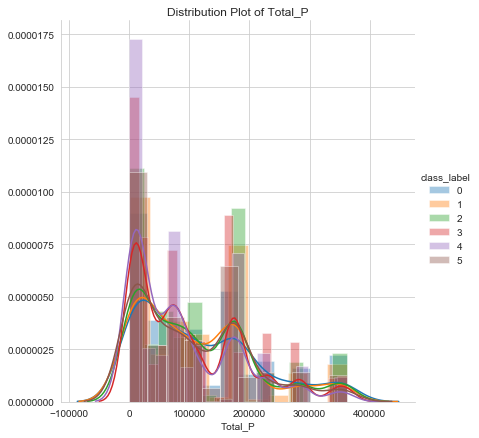

DataFrame with Bad predictions :


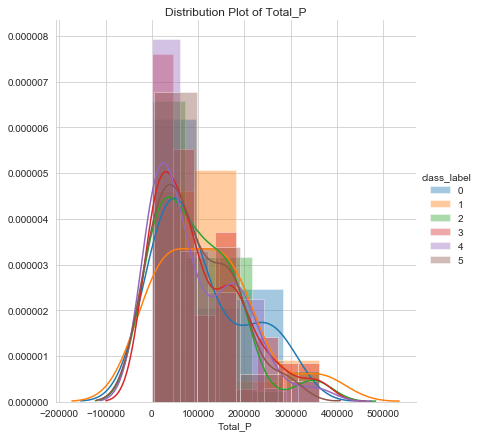

In [370]:
print("DataFrame with Good predictions :")
distribution_plot(df1,'Total_P')
print("DataFrame with Bad predictions :")
distribution_plot(df2,'Total_P')

-  We cannot oberve any major difference between the plots of **Good** and **Bad** points.

DataFrame with Good predictions :


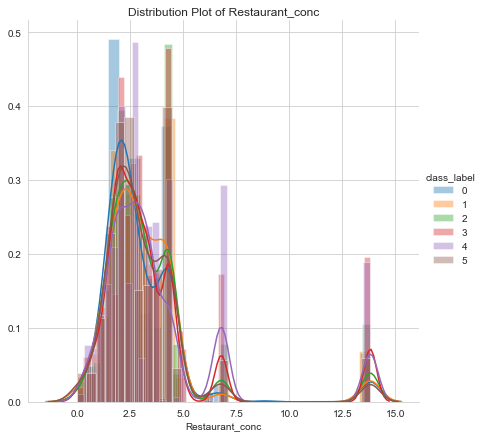

DataFrame with Bad predictions :


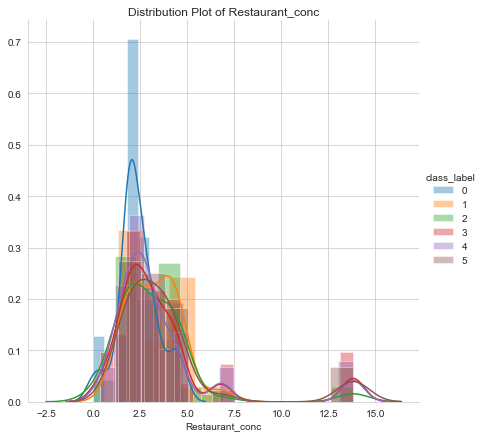

In [371]:
print("DataFrame with Good predictions :")
distribution_plot(df1,'Restaurant_conc')
print("DataFrame with Bad predictions :")
distribution_plot(df2,'Restaurant_conc')

-  We cannot oberve any major difference between the plots of **Good** and **Bad** points.

#### 2.5 Observations

Based on the **EDA** done for both the datasets, we can conclude the following:
-  There seems to be **same distribution** of points for **binary feeatures** for both the data sets.
-  The distribution of **numeric features** also seem to be same for **Good** and **Bad** points.
-  **Categorical features** appear to follow **Power Law** and there seems to a lot of points in **Bad** dataset with multiple categories.
-  We can try to apply **Log Transformation** to the count of **Categorical Features** and convert its distribution based on **Power law**.
-  We should apply **backward feature selection** to check if we can improve our model performance.

### 3. Feature Engineering:

-  From our **EDA**, we have decided to create new features using our **categorical features**
-  Along with that, we had previously ignored **Name** and **Cuisines** from our initial analysis. We would like to create similar features for these 2 features as well.

In [469]:
df = pd.read_csv('result.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'cuisines', 'approx_cost(for two people)',
       'listed_in(type)', 'listed_in(city)', 'avg_user_rating', 'user_votes',
       'total_cuisines', 'multitype_restaurant', 'RevPASH', 'Total_P',
       'Male_P', 'Female_P', 'Grocery_conc', 'Restaurant_conc', 'Cafe_conc',
       'class_label'],
      dtype='object')

In [470]:
# We define a function new_features that takes in the categorical feature
# It replaces the NaN values with an empty space
# We calculate the counts for each category
# We convert the counts to log(counts) and store them in a list based on the Dataframe
# We return the list of new feature


def new_features(DataFrame,feature):
    DataFrame[feature] = DataFrame[feature].replace(np.nan,'')
    z = DataFrame[feature].value_counts()
    x = np.log(z)
    x = dict(x)
    feature_lg=[]
    for i in DataFrame[feature].values:
        feature_lg.append(x[i])
    return feature_lg

In [471]:
loc_lg = new_features(df,'location')
rest_lg = new_features(df,'rest_type')
cuisines_lg = new_features(df,'cuisines')
name_lg = new_features(df,'name')
listed_lg = new_features(df,'listed_in(type)')
df['loc_lg'] = loc_lg
df['rest_lg'] = rest_lg
df['cuisines_lg'] = cuisines_lg
df['name_lg'] = name_lg
df['listed_lg'] = listed_lg

#### 3.1 Observations:

-  We have created 5 new features, **(Log_lg, rest_lg, listed_lg, cuisines_lg and name_lg)**
-  3 of these features are created using the **categorical features** previously used in our analysis **(Location, Listen_in(type) and rest_type)**.
-  2 of them are created using features which weren't used previously **(Name and Cuisines)**

### 4. Model Improvement

Using the new features created, we are going to retrain our best model. We are going to follow **Backward feature selection** to remove some of the unwanted **Categorical features**. After that we will add our new features one by one following **Forward Feature Selection**

In [472]:
df.drop(columns=['rate','class_label'],inplace=True)
X = df.drop('avg_user_rating',axis=1)
y = df['avg_user_rating']
print(X.shape)
print(y.shape)

(46142, 25)
(46142,)


In [473]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(30915, 25) (30915,)
(15227, 25) (15227,)


In [474]:
# We define a function transform_data that takes the train and test data after splitting
# This function performs onehotencoding and normalization of numeric features using the above 2 defined functions
# It resturns all the transformed features indivisually.


def transform_data(X_train,X_test):
    X_train_order,X_test_order = categorical(X_train,X_test,y_train,y_test,'online_order')
    X_train_book,X_test_book = categorical(X_train,X_test,y_train,y_test,'book_table')
    X_train_multi,X_test_multi = categorical(X_train,X_test,y_train,y_test,'multitype_restaurant')
    X_train_location,X_test_location = categorical(X_train,X_test,y_train,y_test,'location')
    X_train_rest,X_test_rest = categorical(X_train,X_test,y_train,y_test,'rest_type')
    X_train_type,X_test_type = categorical(X_train,X_test,y_train,y_test,'listed_in(type)')
    X_train_city,X_test_city = categorical(X_train,X_test,y_train,y_test,'listed_in(city)')

    X_train_votes,X_test_votes = numerical(X_train,X_test,'votes')
    X_train_uv,X_test_uv = numerical(X_train,X_test,'user_votes')
    X_train_cost,X_test_cost = numerical(X_train,X_test,'approx_cost(for two people)')
    X_train_tc,X_test_tc = numerical(X_train,X_test,'total_cuisines')
    X_train_rv,X_test_rv = numerical(X_train,X_test,'RevPASH')
    X_train_tp,X_test_tp = numerical(X_train,X_test,'Total_P')
    X_train_mp,X_test_mp = numerical(X_train,X_test,'Male_P')
    X_train_fp,X_test_fp = numerical(X_train,X_test,'Female_P')
    X_train_gc,X_test_gc = numerical(X_train,X_test,'Grocery_conc')
    X_train_rc,X_test_rc = numerical(X_train,X_test,'Restaurant_conc')
    X_train_cc,X_test_cc = numerical(X_train,X_test,'Cafe_conc')
    X_train_lg,X_test_lg = numerical(X_train,X_test,'loc_lg')
    X_train_restlg,X_test_restlg = numerical(X_train,X_test,'rest_lg')
    X_train_cuisineslg,X_test_cuisineslg = numerical(X_train,X_test,'cuisines_lg')
    X_train_namelg,X_test_namelg = numerical(X_train,X_test,'name_lg')
    X_train_listedlg,X_test_listedlg = numerical(X_train,X_test,'listed_lg')
    
    return X_train_order,X_train_book,X_train_multi,X_train_location,X_train_rest,X_train_type,X_train_city,X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc,X_test_order,X_test_book,X_test_multi,X_test_location,X_test_rest,X_test_type,X_test_city,X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc,X_train_lg,X_test_lg,X_train_restlg,X_test_restlg,X_train_cuisineslg,X_test_cuisineslg,X_train_namelg,X_test_namelg,X_train_listedlg,X_test_listedlg


In [475]:
X_train_order,X_train_book,X_train_multi,X_train_location,X_train_rest,X_train_type,X_train_city,X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc,X_test_order,X_test_book,X_test_multi,X_test_location,X_test_rest,X_test_type,X_test_city,X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc,X_train_lg,X_test_lg,X_train_restlg,X_test_restlg,X_train_cuisineslg,X_test_cuisineslg,X_train_namelg,X_test_namelg,X_train_listedlg,X_test_listedlg = transform_data(X_train,X_test)

#### 4.1 Baseline Model:

This model will have the same number of features as used in our previous analysis. We are using **Stacking Regressor** as obtained intially. This will behave as our **Baseline Model** as we keep adding and removing features.

In [476]:
X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_location,X_train_rest,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_location,X_test_rest,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
X_tr = pd.DataFrame(X_tra.toarray())
X_te = pd.DataFrame(X_tes.toarray())
print(X_tr.shape)
print(X_te.shape)

(30915, 235)
(15227, 235)


Performace metrics for Training Data :
Mean Square Error of the model is 0.014066364403406697
Root Mean Square Error of the model is 0.11860170489249594
R² of the model is 0.9897749124504045


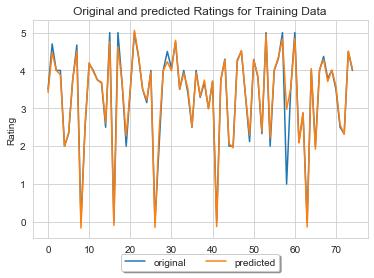

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.2024423837866821
Root Mean Square Error of the model is 0.4499359774308808
R² of the model is 0.8550426047865687


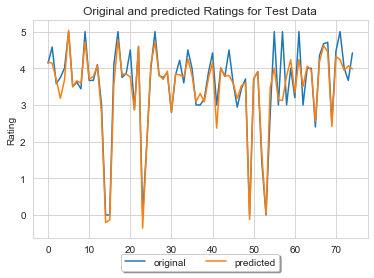

****************************************************************************************************


In [410]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) 
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 4.11 Observations:

-  This model has a **Test RMSE** of **0.4499** which means that our predicted ratings are having a average error value of 0.4499 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.8550** means our model can explain  **85.50%** of the variance in our data, this tells us that this model is able to utilize 85.50% of the features to predict our ratings.

#### 4.2 Baseline (Without Location)

We are removing the **Location Categorical Feature** and running the **Stacking Regressor**.

In [394]:
X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_rest,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_rest,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
X_tr = pd.DataFrame(X_tra.toarray())
X_te = pd.DataFrame(X_tes.toarray()) #without location
print(X_tr.shape)
print(X_te.shape)

(30915, 143)
(15227, 143)


Performace metrics for Training Data :
Mean Square Error of the model is 0.010987847912423803
Root Mean Square Error of the model is 0.10482293600364284
R² of the model is 0.992012740203221


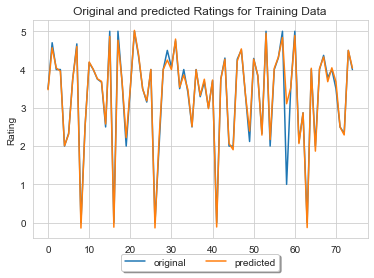

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.20425815497693248
Root Mean Square Error of the model is 0.45194928363360914
R² of the model is 0.8537424350438549


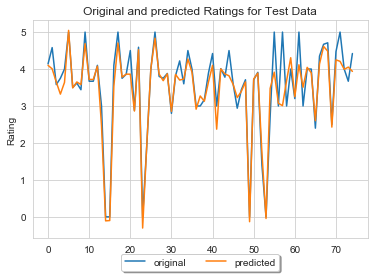

****************************************************************************************************


In [395]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) #without location
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 4.21 Observations:

-  Number of features have come down from **235 to 143 features**
-  The performance of the model has remain almost the same.
-  This model has a **Test RMSE** of **0.4519** which means that our predicted ratings are having a average error value of 0.4519 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.8537** means our model can explain  **85.37%** of the variance in our data, this tells us that this model is able to utilize 85.37% of the features to predict our ratings.
-  Since the performance metric values have reduced negligibly, we can safely assume that **Location** does not add any value to our model and therefore we can remove it.

#### 4.3 Baseline (Without Location and Rest Type)

We continue our **Backward Feature Selection** by removing **Rest_Type** feature and run **Stacking Regressor**

In [396]:
X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
X_tr = pd.DataFrame(X_tra.toarray())
X_te = pd.DataFrame(X_tes.toarray()) 
print(X_tr.shape)
print(X_te.shape) #without location and rest_type

(30915, 54)
(15227, 54)


Performace metrics for Training Data :
Mean Square Error of the model is 0.015137847348479337
Root Mean Square Error of the model is 0.12303595957474928
R² of the model is 0.9889960326626314


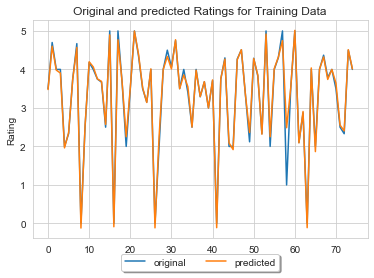

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.23521624395369875
Root Mean Square Error of the model is 0.4849909730641373
R² of the model is 0.8315751207941554


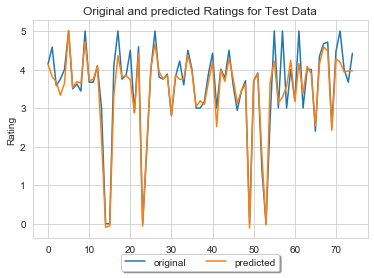

****************************************************************************************************


In [397]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) #without location and rest type
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 4.31 Observations:

-  Number of features have come down from **143 to 54 features**
-  The performance of the model has reduced a bit.
-  This model has a **Test RMSE** of **0.4849** which means that our predicted ratings are having a average error value of 0.4849 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.8315** means our model can explain  **83.15%** of the variance in our data, this tells us that this model is able to utilize 83.15% of the features to predict our ratings.
-  Since the performance metric values have reduced, we cannot remove **Rest_type** as it is adding value to our model.
-  We stop our **Backward Feature Selection**

#### 4.4 Baseline (Without Location) + Loc_lg

We take the model without **Location** Feature and add one of the new ones **(Loc_lg)**, we run with **Stacking Regressor** and measure its performance.

In [398]:
X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_lg,X_train_rest,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_lg,X_test_rest,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
X_tr = pd.DataFrame(X_tra.toarray())
X_te = pd.DataFrame(X_tes.toarray()) #without location, adding Log_location
print(X_tr.shape)
print(X_te.shape)

(30915, 144)
(15227, 144)


Performace metrics for Training Data :
Mean Square Error of the model is 0.010537167529257731
Root Mean Square Error of the model is 0.10265070642356891
R² of the model is 0.9923403476960031


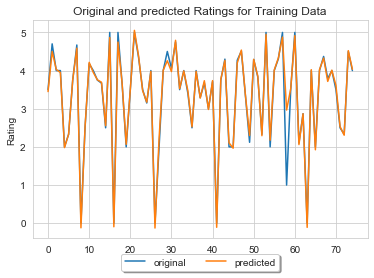

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.20148412085294992
Root Mean Square Error of the model is 0.4488698261778685
R² of the model is 0.8557287619845089


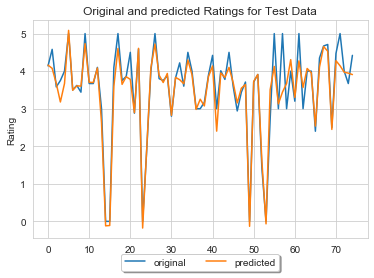

****************************************************************************************************


In [399]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) #without location, adding Log_location
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 4.41 Observations:

-  Number of features have come down from **143 to 144 features**
-  The performance of the model has increased a bit.
-  This model has a **Test RMSE** of **0.4488** which means that our predicted ratings are having a average error value of 0.4488 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.8557** means our model can explain  **85.57%** of the variance in our data, this tells us that this model is able to utilize 85.57% of the features to predict our ratings.
-  Since the performance metric values have increased, we add this new feature and continue with our **Forward Feature Selection**.

#### 4.5 Baseline (Without Location) + (Loc_lg and Rest_lg)

We take our prevoius model and add **(Rest_lg)**, we run with **Stacking Regressor** and measure its performance.

In [400]:
X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_lg,X_train_restlg,X_train_rest,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_lg,X_test_restlg,X_test_rest,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
X_tr = pd.DataFrame(X_tra.toarray())
X_te = pd.DataFrame(X_tes.toarray()) #without location, adding Log_location and log_rest
print(X_tr.shape)
print(X_te.shape)

(30915, 145)
(15227, 145)


Performace metrics for Training Data :
Mean Square Error of the model is 0.010701396859706258
Root Mean Square Error of the model is 0.10344755608377734
R² of the model is 0.9922209665088044


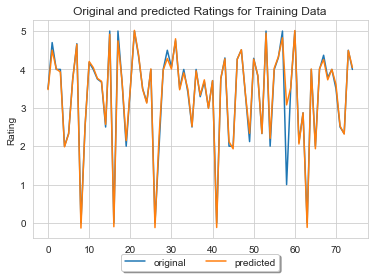

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.19729890830930935
Root Mean Square Error of the model is 0.4441834174181983
R² of the model is 0.8587255529597623


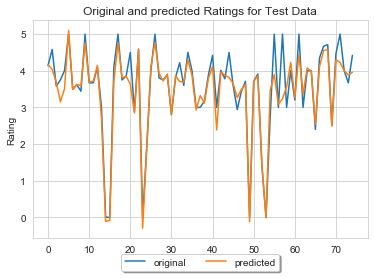

****************************************************************************************************


In [401]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) #without location, adding Log_location and log_rest
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 4.51 Observations:

-  Number of features have come down from **144 to 145 features**
-  The performance of the model has increased a bit.
-  This model has a **Test RMSE** of **0.4441** which means that our predicted ratings are having a average error value of 0.4441 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.8587** means our model can explain  **85.87%** of the variance in our data, this tells us that this model is able to utilize 85.87% of the features to predict our ratings.
-  Since the performance metric values have increased, we add this new feature and continue with our **Forward Feature Selection**.

#### 4.6 Baseline (Without Location) + (Loc_lg, Rest_lg and Cuisines_lg)

We take our prevoius model and add **(Cuisines_lg)**, we run with **Stacking Regressor** and measure its performance.

In [402]:
X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_lg,X_train_restlg,X_train_cuisineslg,X_train_rest,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_lg,X_test_restlg,X_test_cuisineslg,X_test_rest,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
X_tr = pd.DataFrame(X_tra.toarray())
X_te = pd.DataFrame(X_tes.toarray()) #without location, adding Log_location, log_rest and Log_cuisines
print(X_tr.shape)
print(X_te.shape)

(30915, 146)
(15227, 146)


Performace metrics for Training Data :
Mean Square Error of the model is 0.003478721455097976
Root Mean Square Error of the model is 0.05898068713653628
R² of the model is 0.9974712562237888


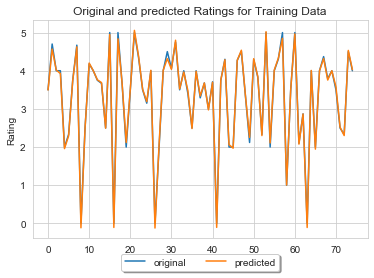

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.16449044608600089
Root Mean Square Error of the model is 0.40557421772839664
R² of the model is 0.8822178135026948


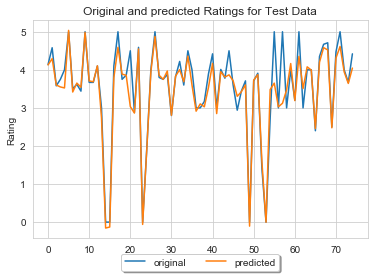

****************************************************************************************************


In [403]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) #without location, adding Log_location, log_rest and Log_cuisines
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 4.61 Observations:

-  Number of features have come down from **145 to 146 features**
-  The performance of the model has increased nicely.
-  This model has a **Test RMSE** of **0.4055** which means that our predicted ratings are having a average error value of 0.4055 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.8822** means our model can explain  **88.22%** of the variance in our data, this tells us that this model is able to utilize 88.22% of the features to predict our ratings.
-  Since the performance metric values have increased, we add this new feature and continue with our **Forward Feature Selection**.

#### 4.7 Baseline (Without Location) + (Loc_lg, Rest_lg, Cuisines_lg and Name_lg)

We take our prevoius model and add **(Name_lg)**, we run with **Stacking Regressor** and measure its performance.

In [404]:
X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_lg,X_train_restlg,X_train_cuisineslg,X_train_namelg,X_train_rest,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_lg,X_test_restlg,X_test_cuisineslg,X_test_namelg,X_test_rest,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
X_tr = pd.DataFrame(X_tra.toarray())
X_te = pd.DataFrame(X_tes.toarray()) #without location, adding Log_location, log_rest, Log_cuisines and Log_names
print(X_tr.shape)
print(X_te.shape)

(30915, 147)
(15227, 147)


Performace metrics for Training Data :
Mean Square Error of the model is 0.002790727288019858
Root Mean Square Error of the model is 0.05282733466700604
R² of the model is 0.9979713712777029


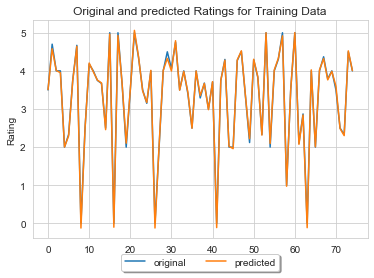

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.14718692443069933
Root Mean Square Error of the model is 0.3836494812073898
R² of the model is 0.8946078742214756


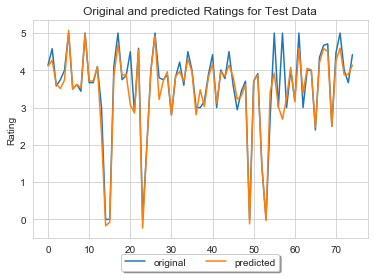

****************************************************************************************************


In [405]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) #without location, adding Log_location, log_rest, Log_cuisines and Log_names
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 4.71 Observations:

-  Number of features have come down from **146 to 147 features**
-  The performance of the model has increased nicely.
-  This model has a **Test RMSE** of **0.3836** which means that our predicted ratings are having a average error value of 0.3836 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.8946** means our model can explain  **89.46%** of the variance in our data, this tells us that this model is able to utilize 89.46% of the features to predict our ratings.
-  Since the performance metric values have increased, we add this new feature and continue with our **Forward Feature Selection**.

#### 4.8 Baseline (Without Location) + (Loc_lg, Rest_lg, Cuisines_lg, Name_lg and Listed_lg)

We take our prevoius model and add **(Listed_lg)**, we run with **Stacking Regressor** and measure its performance.

In [483]:
X_tra = hstack((X_train_order,X_train_book,X_train_multi,X_train_lg,X_train_restlg,X_train_cuisineslg,X_train_namelg,X_train_listedlg,X_train_rest,X_train_type,X_train_city,
               X_train_votes,X_train_uv,X_train_cost,X_train_tc,X_train_rv,X_train_tp,X_train_mp,X_train_fp,X_train_gc,X_train_rc,X_train_cc)).tocsr()
X_tes = hstack((X_test_order,X_test_book,X_test_multi,X_test_lg,X_test_restlg,X_test_cuisineslg,X_test_namelg,X_test_listedlg,X_test_rest,X_test_type,X_test_city,
               X_test_votes,X_test_uv,X_test_cost,X_test_tc,X_test_rv,X_test_tp,X_test_mp,X_test_fp,X_test_gc,X_test_rc,X_test_cc)).tocsr()
X_tr = pd.DataFrame(X_tra.toarray())
X_te = pd.DataFrame(X_tes.toarray())  #without location, adding Log_location, log_rest, Log_cuisines, Log_names and Log_listed
print(X_tr.shape)
print(X_te.shape)

(30915, 148)
(15227, 148)


Performace metrics for Training Data :
Mean Square Error of the model is 0.0015897289207911151
Root Mean Square Error of the model is 0.039871404800823296
R² of the model is 0.9988551690440977


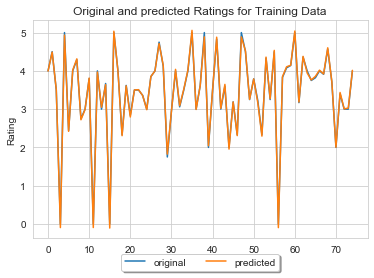

****************************************************************************************************
Performace metrics for Test Data :
Mean Square Error of the model is 0.13427216097656428
Root Mean Square Error of the model is 0.3664316593535066
R² of the model is 0.902009394393386


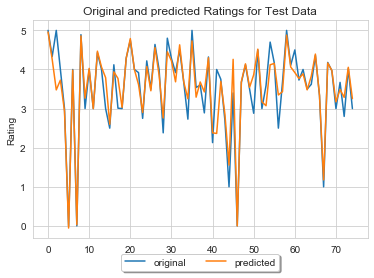

****************************************************************************************************


In [488]:
forest=RandomForestRegressor(max_depth=35,n_estimators=100) #without location, adding Log_location, log_rest, Log_cuisines, Log_names and Log_listed
xgb=XGBRegressor(max_depth=15,n_estimators=100)
lf=LGBMRegressor(max_depth=15,n_estimators=16000)
Sr = StackingRegressor([('rf', forest), ('xgb', xgb),('lgbm',lf)])
metrics(Sr)

#### 4.81 Observations:

-  Number of features have come down from **147 to 148 features**
-  The performance of the model has increased nicely.
-  This model has a **Test RMSE** of **0.3664** which means that our predicted ratings are having a average error value of 0.3664 which is the best we have seen till now.
-  Similarly, **Test R2** of **0.9020** means our model can explain  **90.20%** of the variance in our data, this tells us that this model is able to utilize 90.20% of the features to predict our ratings.
-  Since the performance metric values have increased, we add this new feature.
-  We have sucessfully added all our new features which have all resulted in increasing the performance metrics of our model. 

Average error per prediction : 0.181023622766556


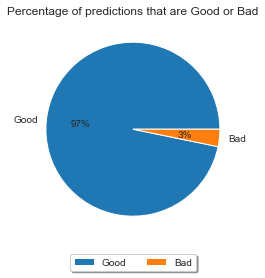

In [491]:
point = analysis(Sr)

#### 4.9 Observations:

-  We can oberve that on a **Rating Error Difference of 1** we have **97% Good** points and **3% Bad** points. This has come down from **5%** which we saw for our **Baseline Model**
-  The model produced an **Average error** of **0.1802** per prediction, which is less than our **Baseline Model** value of **0.238**.
-  From this model analysis, we can safely say that our model has been optimized further as we have reduced the number of **Bad points** by **2**.

### 5. Summary

In [495]:
x = PrettyTable()
x.field_names = ["Model","Feature Engineering","Train_RMSE","Train_R2","Test_RMSE", "Test_R2"]
x.add_row(['Stacking Regressor','No changes',' 0.1186','0.9897',' 0.4499','0.8550'])
x.add_row(['Stacking Regressor','Without C1','0.1048',' 0.9920','0.4519',' 0.8537'])
x.add_row(['Stacking Regressor','Without C1 and C2','0.1230','0.9889','0.4849',' 0.8315'])
x.add_row(['Stacking Regressor','Without C1 + f1',' 0.1026','0.9923','0.4488','0.8538'])
x.add_row(['Stacking Regressor','Without C1 + f1+f2',' 0.1034','0.9922',' 0.4441','0.8587'])
x.add_row(['Stacking Regressor','Without C1 + f1+f2+f3','0.0589','0.9974','0.4055',' 0.8822'])
x.add_row(['Stacking Regressor','Without C1 + f1+f2+f3+f4','0.0528',' 0.9979',' 0.3836','0.8946'])
x.add_row(['Stacking Regressor','Without C1 + f1+f2+f3+f4+f5','0.0398','0.9988','0.3664','0.9020'])

print(x)

+--------------------+-----------------------------+------------+----------+-----------+---------+
|       Model        |     Feature Engineering     | Train_RMSE | Train_R2 | Test_RMSE | Test_R2 |
+--------------------+-----------------------------+------------+----------+-----------+---------+
| Stacking Regressor |          No changes         |   0.1186   |  0.9897  |   0.4499  |  0.8550 |
| Stacking Regressor |          Without C1         |   0.1048   |  0.9920  |   0.4519  |  0.8537 |
| Stacking Regressor |      Without C1 and C2      |   0.1230   |  0.9889  |   0.4849  |  0.8315 |
| Stacking Regressor |       Without C1 + f1       |   0.1026   |  0.9923  |   0.4488  |  0.8538 |
| Stacking Regressor |      Without C1 + f1+f2     |   0.1034   |  0.9922  |   0.4441  |  0.8587 |
| Stacking Regressor |    Without C1 + f1+f2+f3    |   0.0589   |  0.9974  |   0.4055  |  0.8822 |
| Stacking Regressor |   Without C1 + f1+f2+f3+f4  |   0.0528   |  0.9979  |   0.3836  |  0.8946 |
| Stacking

-  We Found out that **Stacking Regressor** was the Best Model for our Dataset.
-  We tried various **EDA** techniques on our new datasets which we divided on the predicted values from our Best Model.
-  We found out a problem with our **Categorical Features** and tried to feature engineer new features.
-  Un-used features like **Name** and **Cuisines** were also feature engineered.
-  The model was optimized using both **Backward Feature Selection** and **Forward Feature Selection**
-  The **Bad** points were reduced from **5%** to **3%** with the **Average Error** per prediction coming down from **0.23** to **0.18**
-  We were able to improve the performance metrics of our **Stacking Regressor** to get a final **Test R2** of **0.9020** and **Test RMSE** of **0.3664**. 